In [ ]:
!pip install deeptrack

In [ ]:
import deeptrack as dt

In [ ]:

import os
import numpy as np
#!pip install git+https://github.com/zalandoresearch/fashion-mnist/utils/mnist_reader.py

if not os.path.exists("fashion-mnist"):
  os.system("git clone https://github.com/zalandoresearch/fashion-mnist")



In [ ]:
import sys
sys.path.append('fashion-mnist/utils')

import mnist_reader

data_dir = 'fashion-mnist/data/fashion'

X_train, y_train = mnist_reader.load_mnist(data_dir, kind='train')

X_test, y_test = mnist_reader.load_mnist(data_dir, kind='t10k')



In [ ]:
print(f"{len(X_train)} training images")
print(f"{len(X_test)} test images")
X_train.shape, y_train.shape



60000 training images
10000 test images


((60000, 784), (60000,))

In [ ]:
y_train_tensor.shape

torch.Size([60000])

In [ ]:
import torch

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
min_val=X_train_tensor.min()
max_val=X_train_tensor.max()


In [ ]:

normalized_X_train_tensor = (X_train_tensor- min_val) / (max_val - min_val)
normalized_y_train_tensor = (y_train_tensor-min_val / max_val - min_val)

In [ ]:
normalized_X_train_tensor.max(), normalized_X_train_tensor.min()

(tensor(1.), tensor(0.))

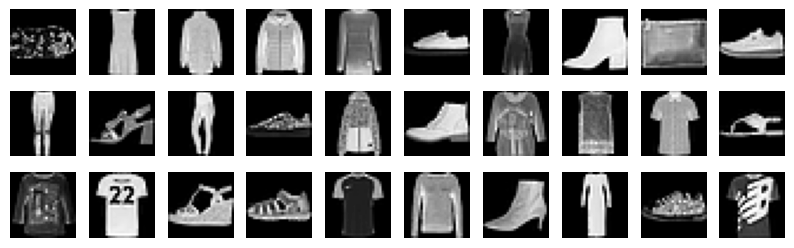

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, train_file in zip(axs.ravel(), np.random.choice(len(normalized_X_train_tensor), axs.size)):
    image = normalized_X_train_tensor[train_file]
    ax.imshow(image.reshape(28,28), cmap="gray")
    ax.set_axis_off()
plt.show()

In [ ]:
!pip install deeplay
import deeplay as dl
from torch.nn import BCELoss



In [ ]:
vae = dl.VariationalAutoEncoder(
    channels=[32, 64],
    latent_dim=2,
    reconstruction_loss=BCELoss(reduction="sum"),
    beta=1,
).create()
print(vae)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
reshape_X_train_tensor = normalized_X_train_tensor.view(-1, 1,28,28)
reshape_y_train_tensor= y_train_tensor.unsqueeze(dim=1)
print(reshape_X_train_tensor.size())
reshape_y_train_tensor.size(), reshape_y_train_tensor


torch.Size([60000, 1, 28, 28])


(torch.Size([60000, 1]),
 tensor([[9],
         [0],
         [0],
         ...,
         [3],
         [0],
         [5]]))

In [ ]:
train_dataset = TensorDataset(reshape_X_train_tensor,reshape_y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")
vae_trainer.fit(vae, train_loader)

INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K
1 | fc_mu               | Linear                 | 6.3 K 
2 | fc_var              | Linear                 | 6.3 K 
3 | fc_dec              | Linear                 | 9.4 K 
4 | decoder             | ConvolutionalDecoder2d | 76.3 K
5 | reconstruction_loss | BCELoss                | 0     
6 | train_metrics       | MetricCollection       | 0     
7 | val_metrics         | MetricCollection       | 0     
8 | test_metrics        | MetricCollection       | 0     
9 | optimizer           | Adam                   | 0     
---------------------------------------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.616     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name                | Type                   

Training: |          | 0/? [00:00<?, ?it/s]

ValueError: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 28, 28])) is deprecated. Please ensure they have the same size.

In [ ]:
from torch.distributions.normal import Normal

img_num, img_size = 21, 28

z0_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))

for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z = torch.stack((z0, z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach()
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size,
        ] = generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z0_grid.numpy(), 1),
)
plt.yticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show()